In [1]:
import scanpy as sc
import scvi 
import anndata
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pandas as pd
import seaborn as sb
import scanpy.external as sce
from tqdm import tqdm

torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scvi.settings.seed = 0

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
scvi.__version__

Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
Global seed set to 0


'0.20.1'

In [ ]:
adata_Fibro = anndata.read_h5ad('adata_Fibro.h5ad')

In [4]:
adata_Fibro

AnnData object with n_obs × n_vars = 95576 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
   

In [10]:
adata = adata_Fibro.copy() 

In [11]:
adata_sub = adata_Fibro[[c not in ['FRZB+ early fibroblast'] for c in adata_Fibro.obs.joint_annotation_20220202] ] 
adata = adata_sub.copy() 
batch = [] 
for i in range(adata.shape[0]):
    batch.append(adata.obs.chemistry_sorting[i] + "_" +  adata.obs.gender[i] +  "_" + adata.obs.donor[i] + "_" + adata.obs.cell_caller[i]  ) 
adata.obs['batch'] = batch 
adata

AnnData object with n_obs × n_vars = 84699 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'b

In [12]:
# remove cell cycle genes
cc_genes = pd.read_csv('regev_lab_cell_cycle_genes.txt', header=None ) # https://notebook.community/theislab/scanpy_usage/180209_cell_cycle/cell_cycle -- 97 CC GENES
cc_genes = np.asarray(cc_genes[0]) 
relevent_cc_genes = [] 
for cc_gene in cc_genes:
    if(cc_gene in adata.var_names):
        relevent_cc_genes.append(cc_gene)
adata = adata[:,np.setdiff1d(adata.var_names,relevent_cc_genes)] 

mito_genes = adata.var_names.str.startswith('MT-') 
total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
total_UMI_count_across_genes = np.sum(adata.X,axis=1).A1 
adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
#sb.distplot(adata.obs['percent_total_mito_UMI']) 

Q1,Q3 = np.percentile(adata.obs['percent_total_mito_UMI'],[25,75])
IQR = Q3-Q1
U = Q3 + (1.5*IQR)
#print(U*100)
adata = adata[adata.obs['percent_total_mito_UMI']<0.08] 
sc.pp.filter_genes(adata, min_cells=3)

def preprocess2(adata):
    sc.pp.normalize_per_cell(adata, 10000) 
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    adata.raw = adata  # keep full dimension safe
    sc.pp.highly_variable_genes(adata, subset=True)
    scvi.settings.seed = 0
    scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
    vae = scvi.model.SCVI(adata, n_layers=2, n_latent=10) # gene_likelihood="nb"
    vae.train()
    adata.obsm["X_scVI"] = vae.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_scVI",method='gauss')
    sc.tl.umap(adata)
    #sc.tl.leiden(adata)
    return adata

adata = preprocess2(adata)

/tmp/ipykernel_8091/814068840.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 34 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 94/94: 100%|██████████| 94/94 [10:27<00:00,  6.56s/it, loss=980, v_num=1]   

`Trainer.fit` stopped: `max_epochs=94` reached.


Epoch 94/94: 100%|██████████| 94/94 [10:27<00:00,  6.67s/it, loss=980, v_num=1]


/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


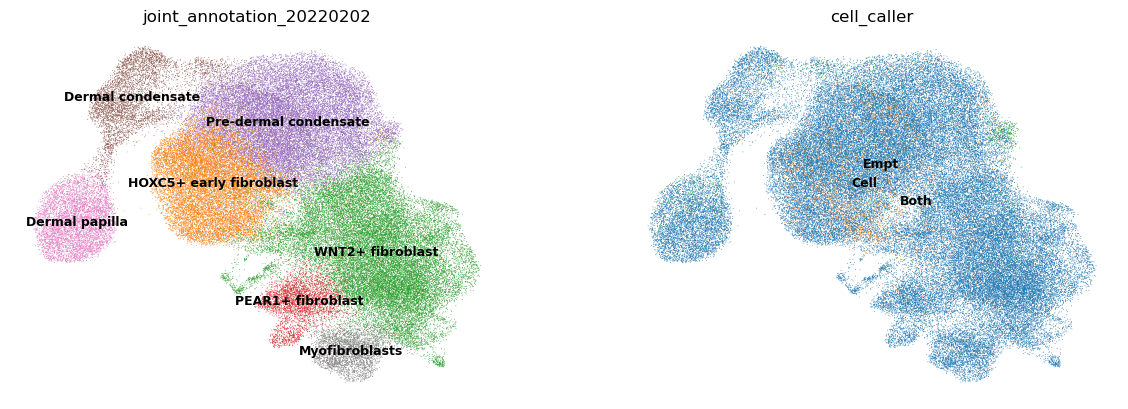

In [13]:
# without removing cell cycle genes
sc.pl.umap(adata, color=['joint_annotation_20220202','cell_caller'], legend_loc='on data', legend_fontsize=9, frameon=False)